# Unsupervised machine learning

After that the dataset has been created and cleaned, it can be fed to models for clustering. However, several methods of data preprocessing can allow to obtain higher performances. As an example numerical values are often scaled before being fed to a machine learning model. Several methods of data preprocessing have been assessed in order to obtain a satisfying clustering.

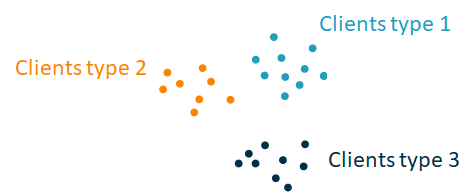

The clusters produced by the model leading to the best clustering have then been studied in order to identify customers’ behaviors in each cluster and conclude if the clustering is relevant.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering

from sklearn.metrics import silhouette_score

from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler

from pca_graph import scree_plot
from pca_graph import correlation_circle
from pca_graph import display_factorial_planes

from scipy.stats import skew

from cluster_evaluation import silhouette_profile

In [2]:
# Custom colors for charts

c_0 = np.array([2, 48, 71,256])/256
c_1 = np.array([251, 133, 0,256])/256
c_2 = np.array([255, 183, 3,256])/256
c_3 = np.array([33, 158, 188,256])/256
c_4 = np.array([142, 202, 230,256])/256

# Creating a custom colormap
# The code comes from https://matplotlib.org/3.1.1/tutorials/colors/colormap-manipulation.html
from matplotlib.colors import ListedColormap

N = 256
vals = np.ones((N, 4))
vals[:, 0] = np.linspace(c_0[0], c_1[0], N)
vals[:, 1] = np.linspace(c_0[1], c_1[1], N)
vals[:, 2] = np.linspace(c_0[2], c_1[2], N)
custom_cmp1 = ListedColormap(vals)

# A colormap with white in the middle
N = 256
vals = np.ones((N, 4))
vals[:, 0] = np.concatenate((np.linspace(c_0[0], 1, 128), np.linspace(1, c_1[0], 128)), axis = None)
vals[:, 1] = np.concatenate((np.linspace(c_0[1], 1, 128), np.linspace(1, c_1[1], 128)), axis = None)
vals[:, 2] = np.concatenate((np.linspace(c_0[2], 1, 128), np.linspace(1, c_1[2], 128)), axis = None)
custom_cmp2 = ListedColormap(vals)

In [3]:
def KMeans_evaluation(x, n_clusters_max=20):
    inertia = []
    silhouette = []
    # Different number of clusters are essayed and the inertia is saved
    for n in range(2, n_clusters_max):
        clt = KMeans(n_clusters = n, random_state = 0)
        clt.fit(x_sc)
        inertia.append(clt.inertia_)
        silhouette.append(silhouette_score(x_sc, clt.labels_))
        
    # Plotting the result
    fig,axes = plt.subplots(1,2, figsize = (10,5))

    axes[0].plot(range(2,n_clusters_max), inertia)
    axes[0].set_xlabel('Number of clusters')
    axes[0].set_ylabel('Inertia')

    axes[1].plot(range(2,n_clusters_max), silhouette)
    axes[1].set_xlabel('Number of clusters')
    axes[1].set_ylabel('Silhouette coef.')

    plt.show()

# 1. Clustering of the RFM values

## 1.1 with raw data

Clustering have first been essayed with raw RFM data without any preprocessing.

In [4]:
# data are imported
df_rfm = pd.read_csv('df_rfm.csv')
df_rfm = df_rfm.sample(10000) # To ease computational time a sample of 10% is employed
df_rfm.head()

recency  frequency  value_total
83666      283          1        52.68
5095       355          4       822.16
27873      368          1       182.59
19523      190          2        89.54
1057       136          1        99.52

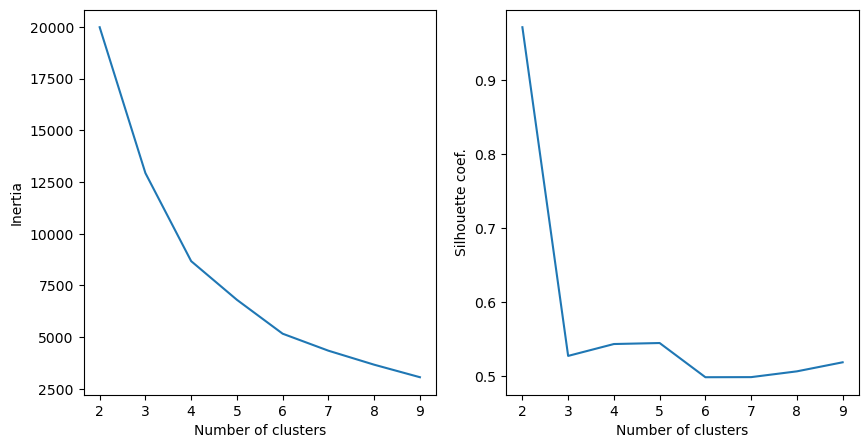

In [5]:
# the data are scaled
x_sc = StandardScaler().fit_transform(df_rfm)

KMeans_evaluation(x_sc, 10)

The inetia and silhouette evaluations offers different results.
- According to the 'elbow rule' the inertia tend to indicate a number of 3, 4 or 5 cluster as an optimum
- According to the general silhouette score, the maximum is obtained for a number f clusters of 2

Thus both are analised in depth.

**Silhouette and computational time analysis**

For n_clusters = 2 The average silhouette_score is : 0.9718198042687267
For n_clusters = 3 The average silhouette_score is : 0.5273418632507952
For n_clusters = 4 The average silhouette_score is : 0.5434098241435433
For n_clusters = 5 The average silhouette_score is : 0.5447465487908248


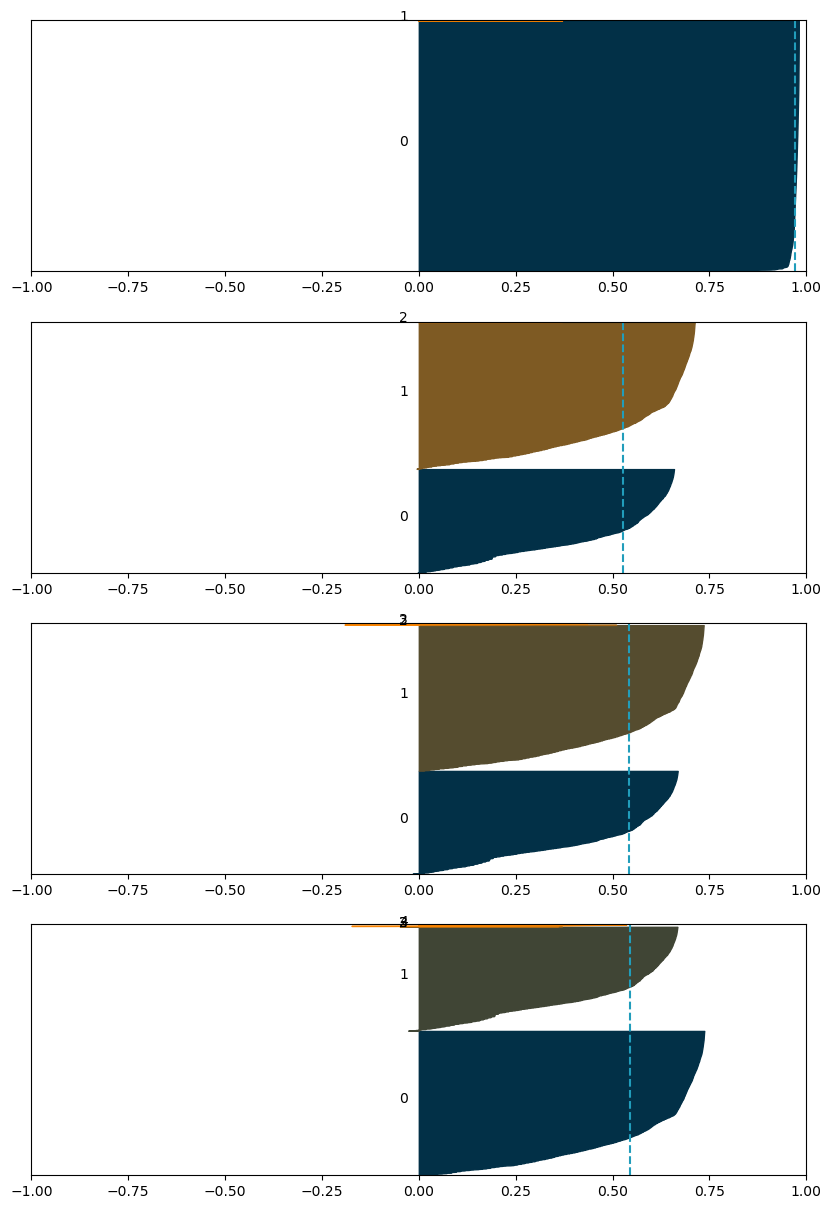

In [6]:
fig, axes = plt.subplots(4,1, figsize = (10,15))

ax_count = 0 # For placing the data in the right ax
for n_cluster in [2,3,4,5]:
    clt = KMeans(n_clusters = n_cluster)
    clt.fit(x_sc)
    
    silhouette_profile(x_sc, clt.labels_, axes[ax_count])
    ax_count +=1

plt.show()

For both number of cluster the silhouette profile analysis shows that clusters are highly unbalanced and present unsatisfying profiles.

The labeling with 2 clusters have been represented in 3D.

In [ ]:
import plotly.express as px
import matplotlib as mpl

clt = KMeans(n_clusters = 3, random_state =0)
clt.fit(x_sc)


fig = px.scatter_3d(x=x_sc[:,0],
                    y=x_sc[:,1],
                    z=x_sc[:,2],
                    color = clt.labels_,
                    color_continuous_scale = [mpl.colors.to_hex(c_0), mpl.colors.to_hex(c_4)], # Add custom color
                    labels = {'x':'Standarised Recency',
                              'y':'Standarised Frequency',
                              'z':'Standarised Monetary value'})
fig.show()

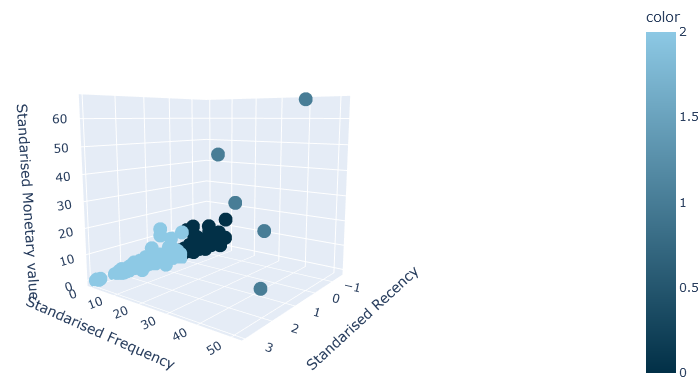

In [ ]:
clt = KMeans(n_clusters = 3, random_state =0)
clt.fit(x_sc)


fig = px.scatter_3d(x=x_sc[:,0],
                    y=x_sc[:,1],
                    z=x_sc[:,2],
                    color = clt.labels_,
                    color_continuous_scale = [mpl.colors.to_hex(c_0), mpl.colors.to_hex(c_4)], # Add custom color
                    labels = {'x':'Standarised Recency',
                              'y':'Standarised Frequency (log)',
                              'z':'Standarised Monetary value (log)'},
                    log_y = True,
                    log_z = True)
fig.show()

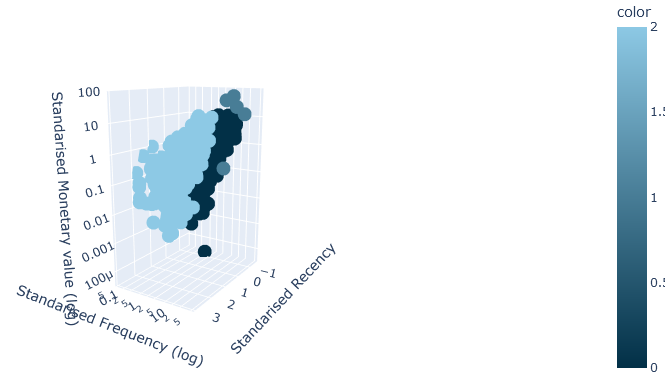

It seems that the clustering separate customers with high frequency and high total value from the others

## 1.2 With log transformation

Some data seems to have low of skewness that could lead to low performances. The skewness of each parameters is measured.

In [9]:
for col in df_rfm.columns:
    print(f'skewness of {col}: {skew(df_rfm[col])}')

skewness of recency: 0.46729022792650693
skewness of frequency: 27.61735537343286
skewness of value_total: 43.300407545603065


Let's verify if log transformation could correct the skewness.

In [10]:
for col in df_rfm.columns:
    print(f'skewness of {col}: {skew(np.log1p(df_rfm[col]))}')

skewness of recency: -1.0688458462493846
skewness of frequency: 3.8394885823102225
skewness of value_total: 1.271329956883575


The skewness of frequency and value_total is improved by log transformation. Thus, the influence of this transformation on the clustering is evaluated.

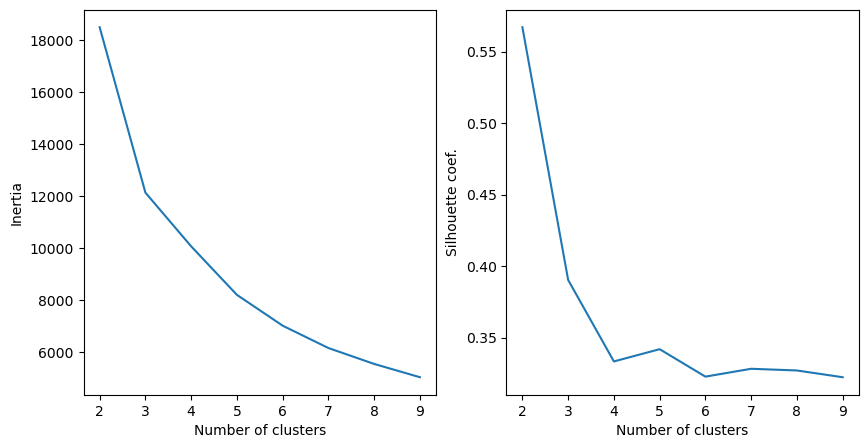

In [11]:
# Data are converted to log
df_rfm_log = df_rfm.copy()
df_rfm_log['frequency'] = np.log1p(df_rfm_log['frequency'])
df_rfm_log['value_total'] = np.log1p(df_rfm_log['value_total'])

# the data are scaled
x_sc = StandardScaler().fit_transform(df_rfm_log)

KMeans_evaluation(x_sc, 10)

Again an elbow at n_clusters = 3, 4 or 5 can be observed.

For n_clusters = 2 The average silhouette_score is : 0.567113615831455
For n_clusters = 3 The average silhouette_score is : 0.39052751994106605
For n_clusters = 4 The average silhouette_score is : 0.33330916385637377
For n_clusters = 5 The average silhouette_score is : 0.34180334094739895


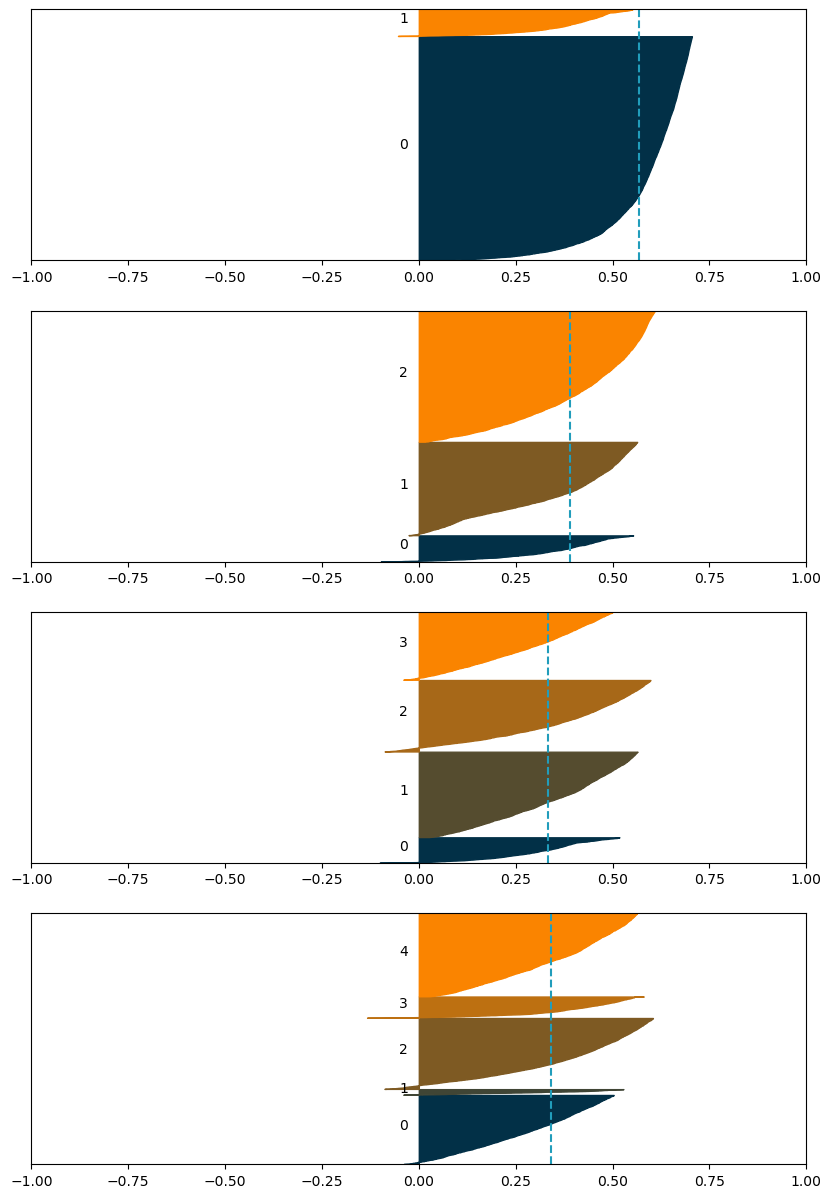

In [12]:
fig, axes = plt.subplots(4,1, figsize = (10,15))

ax_count = 0 # For placing the data in the right ax
for n_cluster in [2,3,4,5]:
    clt = KMeans(n_clusters = n_cluster)
    clt.fit(x_sc)
 
    silhouette_profile(x_sc, clt.labels_, axes[ax_count])
    ax_count +=1

plt.show()

This time the clusters seems better equilibrate. However, the silhouette profile shows that the clusters are still not optimal.

## 1.3 With PCA

By getting rid of unwanted inertia, PCA can improve the performances of the KMeans clustering.

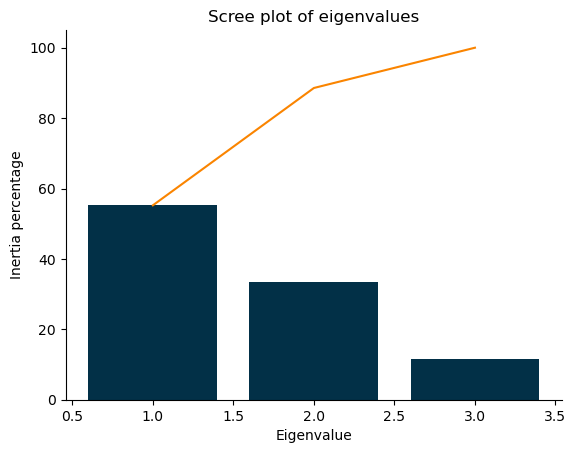

In [13]:
# Data are used are the data converted to log
# the data are scaled
x_sc = StandardScaler().fit_transform(df_rfm_log)

pca = PCA(n_components = 3)
pca.fit(x_sc)

scree_plot(pca)

The two first components explains more than 80% of the inertia and are conserved.

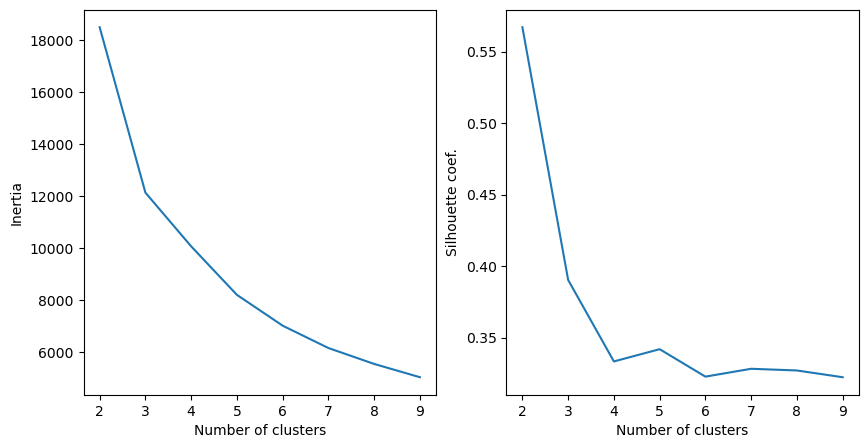

In [14]:
x_pca = PCA(n_components = 2).fit_transform(x_sc)

KMeans_evaluation(x_pca, 10)

For n_clusters = 2 The average silhouette_score is : 0.5911447602747819
For n_clusters = 3 The average silhouette_score is : 0.4478028738884247
For n_clusters = 4 The average silhouette_score is : 0.45472129038031045
For n_clusters = 5 The average silhouette_score is : 0.37745690423105116


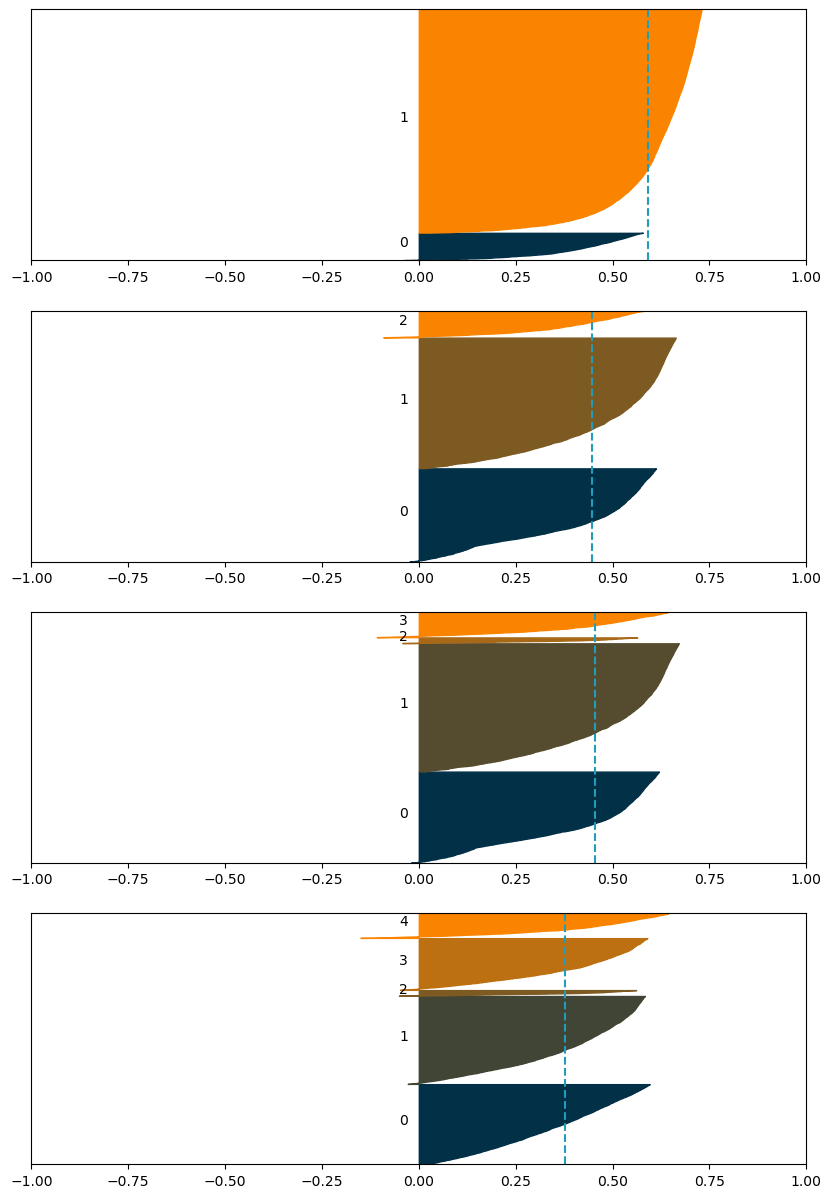

In [15]:
fig, axes = plt.subplots(4,1, figsize = (10,15))

ax_count = 0 # For placing the data in the right ax
for n_cluster in [2,3,4,5]:
    clt = KMeans(n_clusters = n_cluster)
    clt.fit(x_pca)
 
    silhouette_profile(x_pca, clt.labels_, axes[ax_count])
    ax_count +=1

plt.show()

The PCA doen't change much the performances of clustering.

# 2. Clustering with an extended number of features

The whole dataset of engineered features is imported. The influence of adding each features to the RFM dataset on the clustering model have been assessed.

In [16]:
df = pd.read_csv('df_num.csv')
df.head()

review_score_mean  review_message_count  weight_mean  value_total  \
0                5.0                     1       1500.0       141.90   
1                4.0                     0        375.0        27.19   
2                3.0                     0       1500.0        86.22   
3                4.0                     1        150.0        43.62   
4                5.0                     0       6050.0       196.89   

   value_mean  installments_mean  recency  delivery_time  delay  volume_mean  \
0      141.90                8.0      115             10   -5.0       7616.0   
1       27.19                1.0      118              7   -5.0       5148.0   
2       86.22                8.0      541             27   -2.0      43750.0   
3       43.62                4.0      325             31  -12.0       1045.0   
4      196.89                6.0      292             20   -8.0        528.0   

   ...  construction  garden  auto  divers_gifts  sport  clothing  \
0  ...           0.0     0.0   0.0           0.0    0.0       0.0   
1  ...           0.0     0.0   0.0           0.0    0.0       0.0   
2  ...           0.0     0.0   0.0           0.0    0.0       0.0   
3  ...           0.0     0.0   0.0           0.0    0.0       0.0   
4  ...           0.0     0.0   0.0           0.0    0.0       0.0   

   small_housewares  large_housewares  other  seniority  
0               1.0               0.0    0.0          0  
1               0.0               0.0    0.0          0  
2               0.0               0.0    0.0          0  
3               0.0               0.0    0.0          0  
4               0.0               0.0    0.0          0  

[5 rows x 31 columns]

## 2.1 With raw data

In [17]:
# A sample of the data is taken to improve computational performances
df_sample = df.sample(10000)

In [18]:
# Skewness is measured before or after log transformation
for col in df_sample:
    if (abs(skew(np.log1p(df_sample[col]))) - abs(skew(df_sample[col]))) < 0:
        print(col)

review_message_count
weight_mean
value_total
value_mean
installments_mean
delivery_time
volume_mean
density
preciousness
distance
frequency
professional
electronics
food_drinks
healthcare
art
multimedia
books
construction
garden
auto
divers_gifts
sport
clothing
small_housewares
large_housewares
other
seniority


C:\Users\alfre\anaconda3\envs\Project_3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning:

divide by zero encountered in log1p

C:\Users\alfre\anaconda3\envs\Project_3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning:

invalid value encountered in log1p



A list of the features that are not onehot encoded and better represented in log is created

In [19]:
log_list = [
    'review_message_count',
    'weight_mean',
    'value_total',
    'value_mean',
    'installments_mean',
    'delivery_time',
    'volume_mean',
    'density',
    'preciousness',
    'distance',
    'frequency'
]

In [20]:
# Data are converted to log
for col in log_list:
    df_sample[col] = np.log1p(df_sample[col])


In order to assess iteratively the features, one by one, they are added, the model is evaluated before being withdrawn for evaluating the next feature.

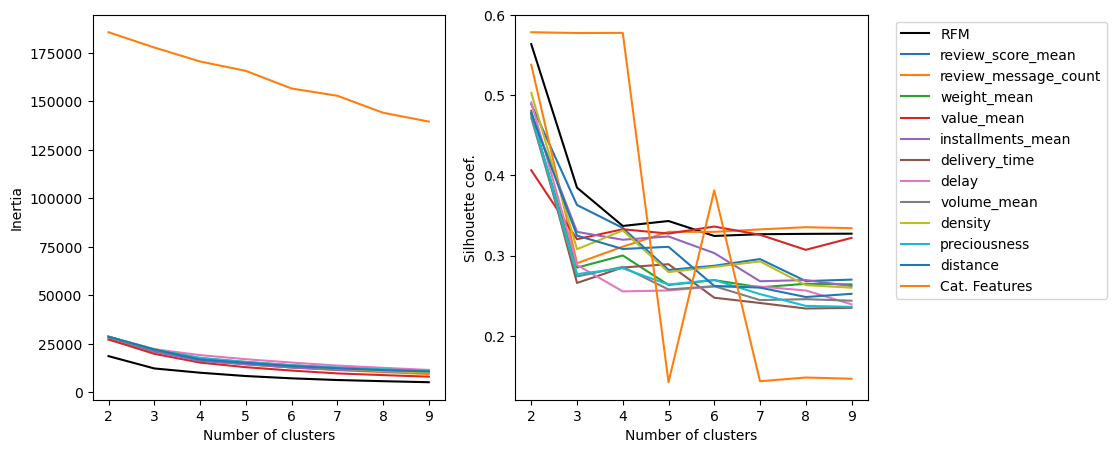

In [21]:
# First the data for RFM Alone are displayed

## the data are scaled
x_sc = StandardScaler().fit_transform(df_sample[['recency', 'value_total', 'frequency']])

inertia = []
silhouette = []
n_clusters_max = 10 # Number max of cluster to be evaluated
## Different number of clusters are essayed and the inertia is saved
for n in range(2, n_clusters_max):
    clt = KMeans(n_clusters = n, random_state = 0)
    clt.fit(x_sc)
    inertia.append(clt.inertia_)
    silhouette.append(silhouette_score(x_sc, clt.labels_))
        
## Plotting the result
fig,axes = plt.subplots(1,2, figsize = (10,5))
axes[0].plot(range(2,n_clusters_max), inertia, label = 'RFM', color = 'black')
axes[1].plot(range(2,n_clusters_max), silhouette, label = 'RFM', color = 'black')



# Then features are added and withdrawn one by one except for categorical features that are added together

features_list = ['review_score_mean',
                 'review_message_count',
                 'weight_mean',
                 'value_mean',
                 'installments_mean',
                 'delivery_time',
                 'delay',
                 'volume_mean',
                 'density',
                 'preciousness',
                 'distance',
                 ['professional', 'electronics', 'food_drinks',
                 'healthcare', 'art', 'multimedia',
                 'books', 'construction', 'garden',
                 'auto', 'divers_gifts', 'sport',
                 'clothing', 'small_housewares', 'large_housewares',
                 'other', 'seniority']]



for index, added_feature in enumerate(features_list):
    if type(added_feature) != list: # For concatenation, added label must be a list
        label = added_feature
        added_feature = [added_feature]
    else:
        label = 'Cat. Features'
        
    df_eval = df_sample[['recency', 'value_total', 'frequency'] + added_feature]
    
    # the data are scaled
    x_sc = StandardScaler().fit_transform(df_eval)
    
    inertia = []
    silhouette = []
    ## Different number of clusters are essayed and the inertia is saved
    for n in range(2, n_clusters_max):
        clt = KMeans(n_clusters = n, random_state = 0)
        clt.fit(x_sc)
        inertia.append(clt.inertia_)
        silhouette.append(silhouette_score(x_sc, clt.labels_))
        
    ## Plotting the result
    axes[0].plot(range(2,n_clusters_max), inertia, label = label)
    axes[1].plot(range(2,n_clusters_max), silhouette, label = label)


axes[0].set_xlabel('Number of clusters')
axes[0].set_ylabel('Inertia')   

axes[1].set_xlabel('Number of clusters')
axes[1].set_ylabel('Silhouette coef.')

axes[1].legend(loc = 'upper right', bbox_to_anchor = (1.7, 1))

plt.show()

For most of the new features, their inclusion in the model reduce the silhouette coeficient. The only exceptions are *value mean*, *review score mean*, *review message count* and *Cat. Features*.

However :
- *Cat. Features* leads to highly complex clusters that are difficult to interpret and increase significantly the inertia.
- *value mean* and *review_message_count* favorise a high number of clusters (above 5) that are unbalanced and difficult to interptret.

Thus, *review_score_mean* is kept as a parameter to improve interpretation of the clusters.

For n_clusters = 2 The average silhouette_score is : 0.48896642077774294
For n_clusters = 3 The average silhouette_score is : 0.3630990756314398
For n_clusters = 4 The average silhouette_score is : 0.3343859276407374
For n_clusters = 5 The average silhouette_score is : 0.28117787081488704


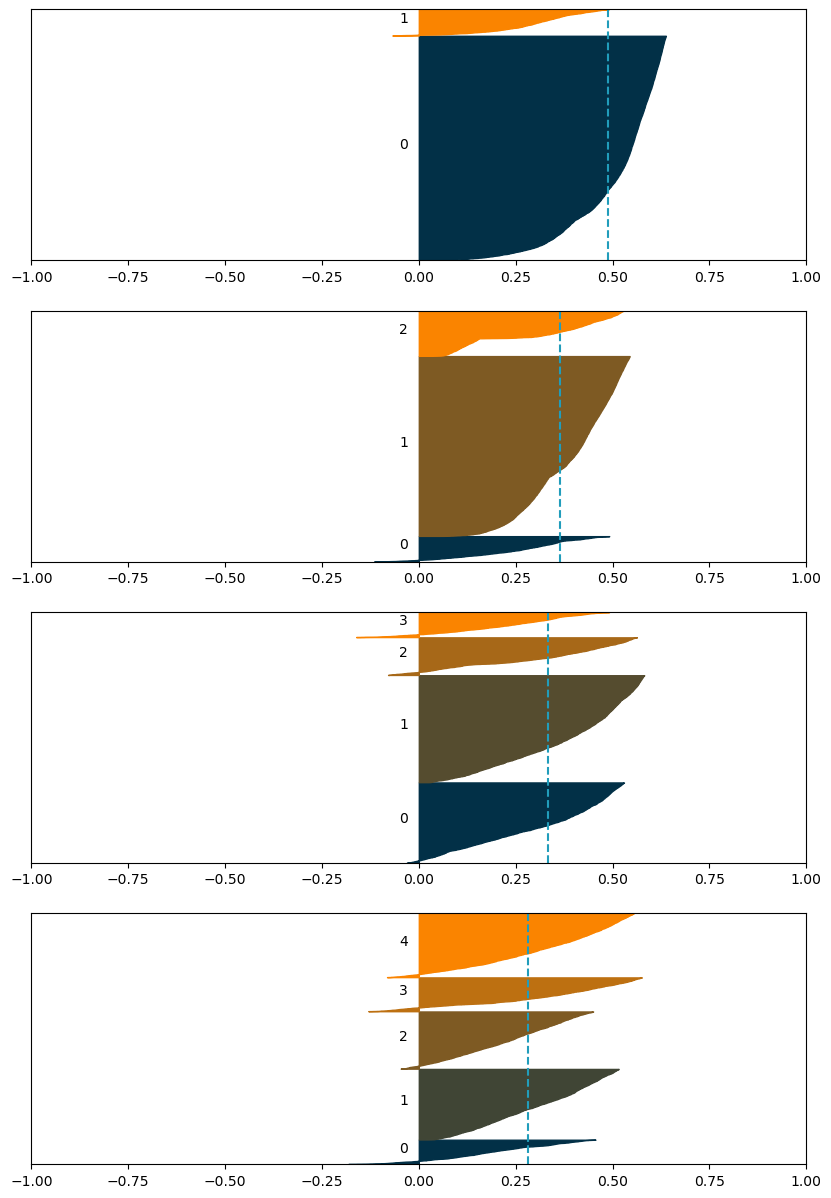

In [22]:
         
# the data are scaled
x_sc = StandardScaler().fit_transform(df_sample[['recency', 'value_total', 'frequency', 'review_score_mean']])

fig, axes = plt.subplots(4,1, figsize = (10,15))

ax_count = 0 # For placing the data in the right ax
for n_cluster in [2,3,4,5]:
    clt = KMeans(n_clusters = n_cluster)
    clt.fit(x_sc)
 
    silhouette_profile(x_sc, clt.labels_, axes[ax_count])
    ax_count +=1

plt.show()

Four clusters seems to result in balanced clusters but with still unsatisfying profiles.

## 2.2 With prior PCA

From the EDA we know that a lot of data are correlated, thus prior PCA could allow to facilitate clustering.

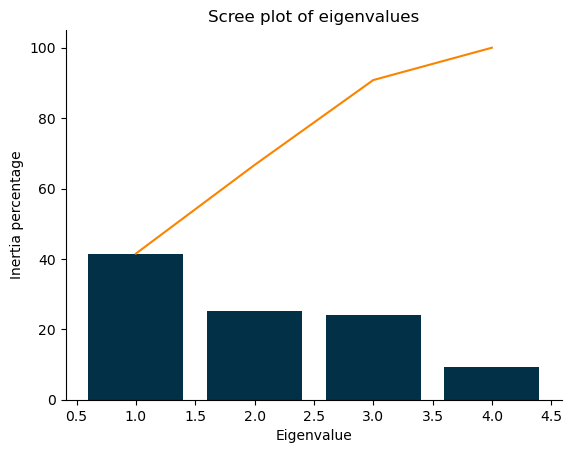

In [23]:
pca = PCA(n_components = x_sc.shape[1])
pca.fit(x_sc)

scree_plot(pca)

The inertia seems highly repartied among the 3 first components.

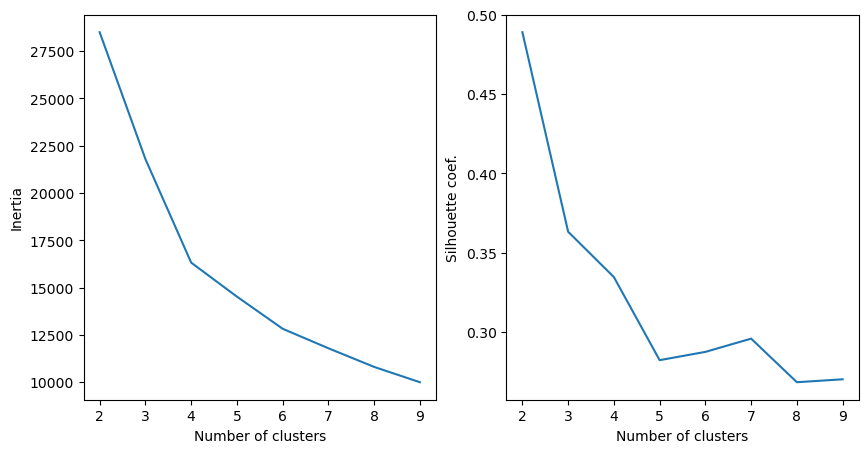

In [24]:
x_pca = PCA(n_components = 3).fit_transform(x_sc)

KMeans_evaluation(x_pca, 10)

For n_clusters = 4 The average silhouette_score is : 0.33446250784543174


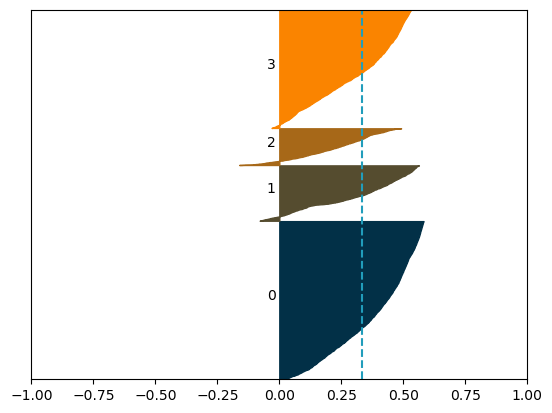

In [25]:
clt = KMeans(n_clusters = 4)
clt.fit(x_sc)


fig, ax = plt.subplots()
silhouette_profile(x_sc, clt.labels_, ax)

plt.show()

Similar results are obtained, the PCA doesn't improve the clustering

## 2.2 With categories ordinaly encoded

The one hot encoding employed for the categorical data could hinder the clustering capacities. Thus, data encoded with ordial encoding are evaluated.

In [26]:
df_enc = pd.read_csv('df_enc.csv', index_col = 0)
df_sample = df_enc.sample(10000)

In [27]:
# Converting log features

for col in log_list:
    df_sample[col] = np.log1p(df_sample[col])

In [28]:
df_enc.columns

Index(['customer_state', 'review_score_mean', 'review_message_count',
       'weight_mean', 'value_total', 'value_mean', 'installments_mean',
       'payment_type', 'recency', 'delivery_time', 'delay', 'volume_mean',
       'density', 'preciousness', 'distance', 'frequency', 'seniority',
       'main_category'],
      dtype='object')

The features are again tested independantely.

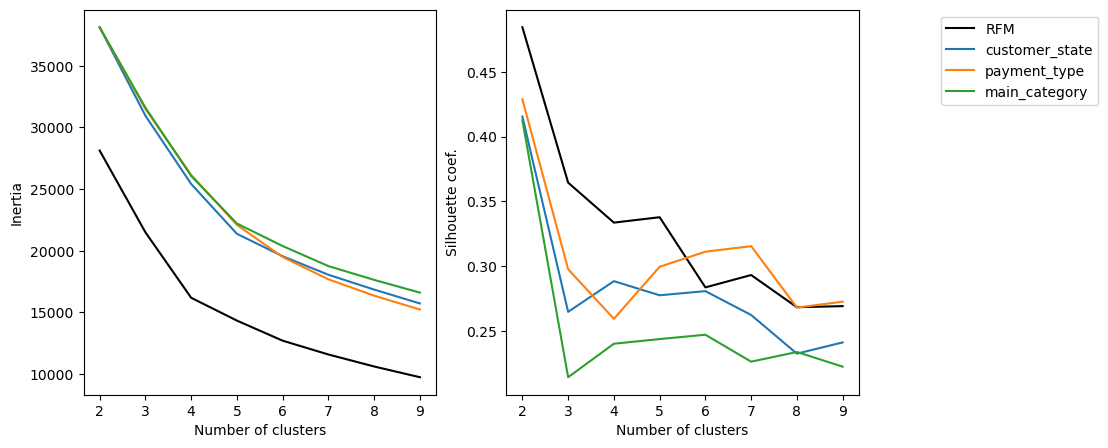

In [29]:
# First the data for RFM Alone are displayed

## the data are scaled
x_sc = StandardScaler().fit_transform(df_sample[['recency', 'value_total', 'frequency', 'review_score_mean']])

inertia = []
silhouette = []
n_clusters_max = 10 # Number max of cluster to be evaluated
## Different number of clusters are essayed and the inertia is saved
for n in range(2, n_clusters_max):
    clt = KMeans(n_clusters = n, random_state = 0)
    clt.fit(x_sc)
    inertia.append(clt.inertia_)
    silhouette.append(silhouette_score(x_sc, clt.labels_))
        
## Plotting the result
fig,axes = plt.subplots(1,2, figsize = (10,5))
axes[0].plot(range(2,n_clusters_max), inertia, label = 'RFM', color = 'black')
axes[1].plot(range(2,n_clusters_max), silhouette, label = 'RFM', color = 'black')



# Then features are added and withdrawn one by one except for categorical features that are added together

features_list = ['customer_state',
                 'payment_type',
                 'main_category']



for index, added_feature in enumerate(features_list):
    if type(added_feature) != list: # For concatenation, added label must be a list
        label = added_feature
        added_feature = [added_feature]
    else:
        label = 'Cat. Features'
        
    df_eval = df_sample[['recency', 'value_total', 'frequency', 'review_score_mean'] + added_feature]
    
    # the data are scaled
    x_sc = StandardScaler().fit_transform(df_eval)
    
    inertia = []
    silhouette = []
    ## Different number of clusters are essayed and the inertia is saved
    for n in range(2, n_clusters_max):
        clt = KMeans(n_clusters = n, random_state = 0)
        clt.fit(x_sc)
        inertia.append(clt.inertia_)
        silhouette.append(silhouette_score(x_sc, clt.labels_))
        
    ## Plotting the result
    axes[0].plot(range(2,n_clusters_max), inertia, label = label)
    axes[1].plot(range(2,n_clusters_max), silhouette, label = label)


axes[0].set_xlabel('Number of clusters')
axes[0].set_ylabel('Inertia')   

axes[1].set_xlabel('Number of clusters')
axes[1].set_ylabel('Silhouette coef.')

axes[1].legend(loc = 'upper right', bbox_to_anchor = (1.7, 1))

plt.show()

For n_clusters = 6 The average silhouette_score is : 0.3112427584587076


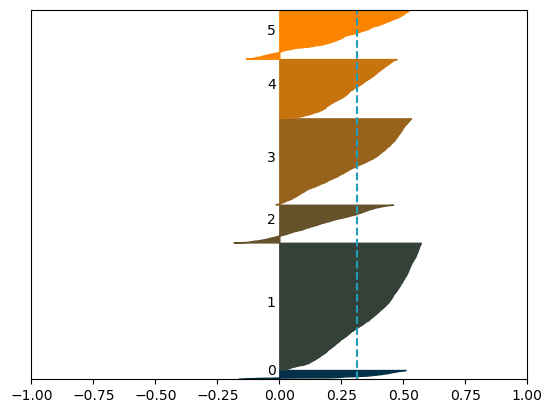

In [30]:
x_sc = StandardScaler().fit_transform(df_sample[['recency', 'value_total', 'frequency','review_score_mean', 'payment_type']])

clt = KMeans(n_clusters = 6)
clt.fit(x_sc)


fig, ax = plt.subplots()
silhouette_profile(x_sc, clt.labels_, ax)

plt.show()

It seems that the ordinal encoded features do not improve significantly the clustering and a are thus not kept.

# 3. Clustering model evaluation on RFM+

We saw that the best clustering perfomances were obtained with the RFM Log system with adding reviewn score mean. However, only the KMeans model have been essayed. Other models (DBSCAN and Hierarchical clustering) will be assessed.

**DBSCAN**

In [31]:
clt_dbscan = DBSCAN(eps = 0.8,
                    min_samples = 75)

# the data are scaled
x_sc = StandardScaler().fit_transform(df_sample[['recency', 'value_total', 'frequency', 'review_score_mean']])

clt_dbscan.fit(x_sc)

DBSCAN(eps=0.8, min_samples=75)

In [32]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components =2,
            perplexity = 60,
            n_iter = 3000,
            learning_rate = 'auto').fit_transform(x_sc)


C:\Users\alfre\anaconda3\envs\Project_3\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.



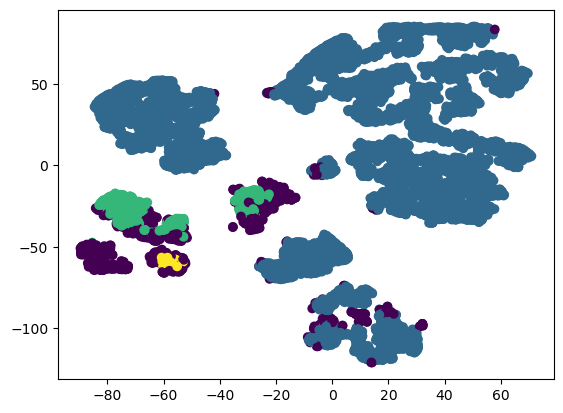

In [33]:
plt.scatter(tsne[:,0], tsne[:,1], c = clt_dbscan.labels_)

For n_clusters = 4 The average silhouette_score is : 0.263769894245133


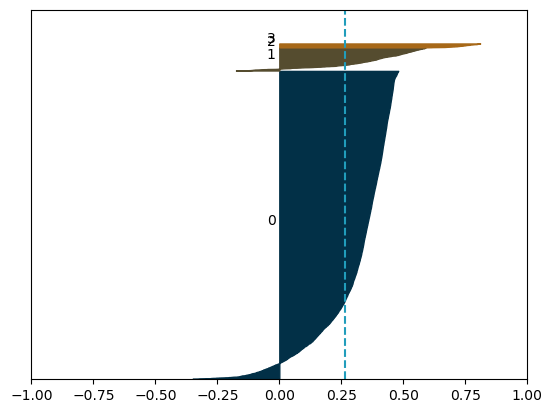

In [34]:
fig, ax = plt.subplots()
silhouette_profile(x_sc, clt_dbscan.labels_, ax)

plt.show()

Even after multiple steps of optimisation, the DBSCAN do not seems to offer a better result than with the KMeans.

**Hierarchical Clustering**

In [35]:
clt_hie = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

# the data are scaled
x_sc = StandardScaler().fit_transform(df_sample[['recency', 'value_total', 'frequency', 'review_score_mean']])

clt_hie.fit(x_sc)

AgglomerativeClustering(distance_threshold=0, n_clusters=None)

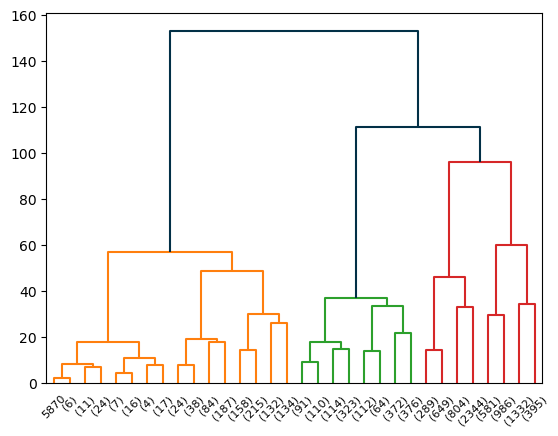

In [36]:
from plot_dendrogram import plot_dendrogram

plot_dendrogram(clt_hie, truncate_mode="level", p=4, above_threshold_color = mpl.colors.to_hex(c_0))
plt.show()

An optimum could be 4 levels

For n_clusters = 4 The average silhouette_score is : 0.2894079663740015


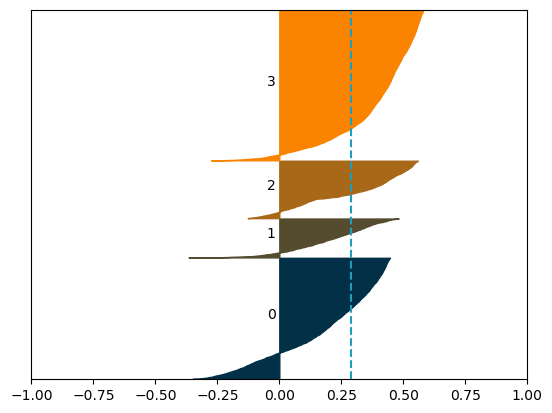

In [37]:
clt_hie = AgglomerativeClustering(n_clusters=4)
clt_hie.fit(x_sc)

fig, ax = plt.subplots()
silhouette_profile(x_sc, clt_hie.labels_, ax)

plt.show()

Results resembling to KMeans but less satisfying are obtained.

# 4. Clusters interpretation

The retained model is the KMeans forming 4 clusters with the features *recency*, *value_total*, *frequency* and *review_score_mean*. The statistics of the clusters produced by the model have been studied in detail in order to better understand the customer behaviors in each cluster.

In [42]:
df_total = df[['recency', 'value_total', 'frequency', 'review_score_mean']]

# Log data are converted
df_total.loc[:,'value_total'] = np.log1p(df_total['value_total'])
df_total.loc[:,'frequency'] = np.log1p(df_total['frequency'])

# Data are standardised
x_sc = StandardScaler().fit_transform(df_total)

clt = KMeans(n_clusters = 4, random_state = 0)
clt.fit(x_sc)

C:\Users\alfre\AppData\Local\Temp\ipykernel_15072\2936969210.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\alfre\AppData\Local\Temp\ipykernel_15072\2936969210.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



KMeans(n_clusters=4, random_state=0)

In [43]:
# Watching statistics

# Clusters are renamed counting from 1
for n in range(4):
    print(f'\nCluster n°{n+1}')
    print(df_total[clt.labels_ == n].describe())


Cluster n°1
            recency   value_total     frequency  review_score_mean
count  14192.000000  14192.000000  14192.000000       14192.000000
mean     243.625000      4.729213      0.725295           1.673960
std      131.160257      0.811596      0.137937           0.849813
min        0.000000      2.693275      0.693147           1.000000
25%      161.000000      4.157750      0.693147           1.000000
50%      222.000000      4.676374      0.693147           1.000000
75%      305.000000      5.230400      0.693147           3.000000
max      728.000000      8.066380      2.079442           3.000000

Cluster n°2
            recency   value_total     frequency  review_score_mean
count  29681.000000  29681.000000  29681.000000       29681.000000
mean     396.104983      4.659281      0.718587           4.640345
std       95.361513      0.785682      0.113583           0.587026
min      258.000000      2.404239      0.693147           2.000000
25%      312.000000      4.110218   

The proportion of customer per cluster is displayed as a pie chart.

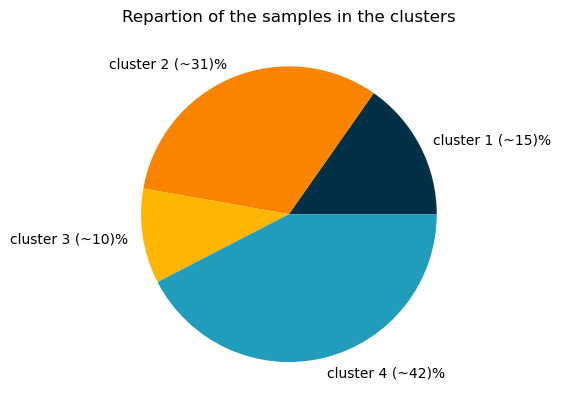

In [44]:
# Repartition is looked at
plt.pie([np.sum(clt.labels_ == n) for n in range(4)],
        labels =[f'cluster {n+1} (~{int(np.sum(clt.labels_ == n)/clt.labels_.shape[0]*100)})%' for n in range(4)],
        colors = [c_0, c_1, c_2, c_3])
plt.title('Repartion of the samples in the clusters')
plt.show()

Then, complete statistics per features and per clusters are displayed.

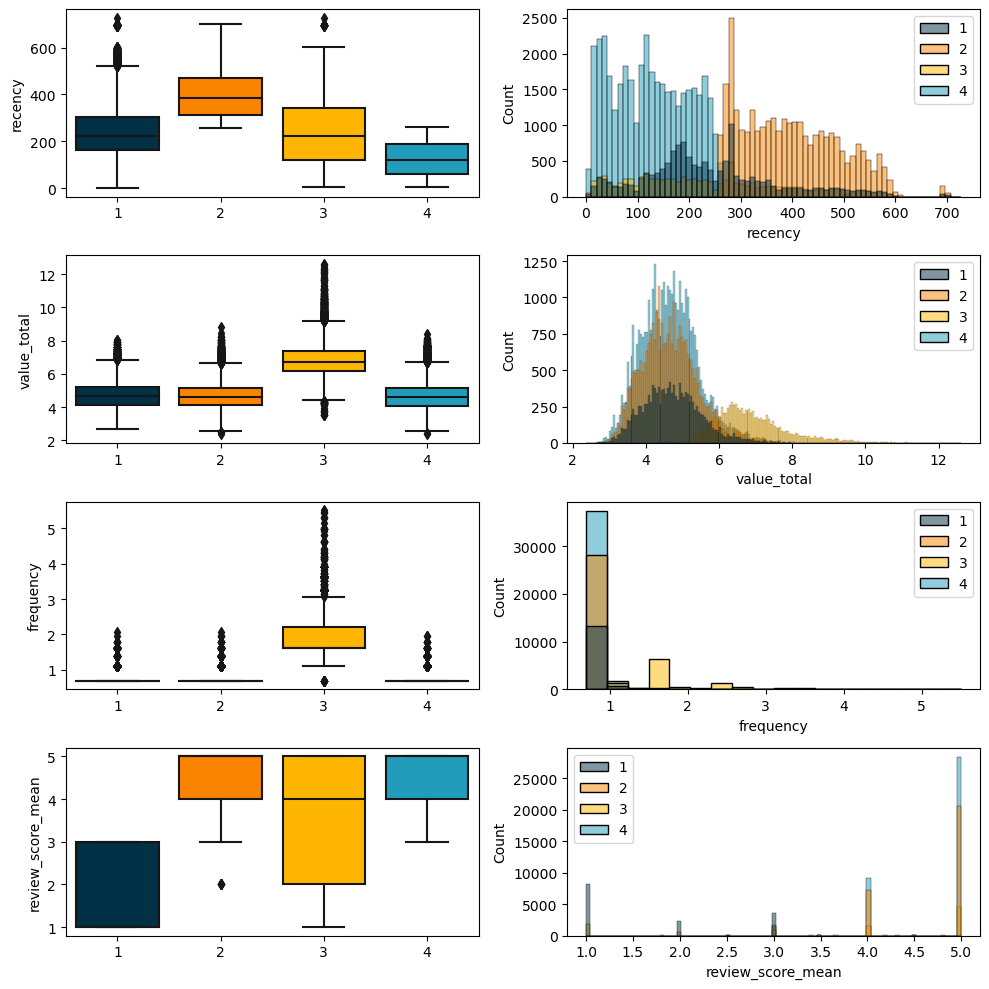

In [45]:
fig, axes = plt.subplots(df_total.shape[1], 2, figsize = (10,10))

for index, feature in enumerate(df_total.columns):
    sns.boxplot(data = df_total, y = feature, x = clt.labels_+1, ax = axes[index, 0], palette = [c_0, c_1, c_2, c_3], saturation = 1)
    sns.histplot(data = df_total, x = feature, hue = clt.labels_+1, ax = axes[index, 1], palette = [c_0, c_1, c_2, c_3], )

plt.tight_layout()

The clusters can be described as follow :

- **Cluster 1**:
    Customer with average recency but low total monetary value and frequency but more importantly low review scores.
    
    This cluster correspond to clients that are unhappy with their order.


- **Cluster 2**:
    Customer with low total monetary value and frequency but high recency.
    
    This cluster correspond to clients that ordered few times (mostly once) from the platform but (oposit to cluster 0) a long time ago. They are clients that could be potentialy considered as 'no longer visiting the platform'. The grading of products is similar to recent clients that recently joined the platform (Cluster 4).
    
    
- **Cluster 3**:

    Customers with average recency and total monetary value but with high frequency and a broad review score.
    
    This cluster correpond to clients that order or ordered in the past multiple times from the platform. They generaly attributed good grades to the products with some exception that could be investigated.
    

- **Cluster 4**:

    Customer with low recency, total monetary value and frequency but high review score.
    
    This cluster correpond to recent clients that haven't allready ordered much. They seems to be generaly happy according to the review score.
    
    

    
    

    